# Boostrap

All materials are taken from article (in Russian): https://habr.com/ru/companies/X5Tech/articles/679842/

Here we will consider how with use of Bootstrap we can evaluate Standard Deviation, Build Confidence Intervals and Test Hypothesis.  
We will see when Bootstrap is irreplaceable and what disadvantages it has.

# Metrics and their accuracy:

Imaging that we analyze data of deliveries from Online Shop.  
We want to understand how good our delivery is. We have data on delivery time for each order. Therefore, we can choose metric and evaluate it.  
Assume that we work with independent equally distributed random variables.

The most intuitive metric in such case - Average Time of delivery.  
To calculate Average time we can take all orders in some period of time, for example in last month and calculate average delivery time.

Assume that we calculate this metric = 90 minutes.  
In what extend we can trust this value? Obviously, it can not be True value on all future deliveries. In next month we can get different value.  
Therefore, it is important to evaluate Standard Deviation to understand how accurate is evaluation: 90+-1 minute is very different from 90+-30 minutes.

![](./pic/4.png)

where n - size of subset, Xi - random number of delivery time, $X^-$ - mean of delivery time for subset

Example Mean and SD (Standard Deviation):  
- dataset of 1000 deliveries
- distribution will be generated using Normal distribution function (in real life case distribution can be not normal):
    - mean = 90
    - standard deviation = 20

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import numpy as np

n = 1000
values = np.random.normal(90, 20, n)
mean = values.mean()
std = values.std() / np.sqrt(n)
print(f'Mean = {mean:0.2f}')
print(f'STD = {std:0.2f}')

Mean = 90.05
STD = 0.62


in that example, number of values was enough to make SD less than 1 minute

# Quantiles

We have evaluated Average time of delivery. It gives us some idea about current situation, but it is only one number. Some people get their deliveries fast others - slow.  
We want our clients to fill happy, therefore we want to make sure that the majority of clients get their deliveries fast enough.

We can evaluate how fast Majority of orders are delivered, for example using 90% quantile.  
What is the physical sense of quantile? If 90% quantile = 2 hours, it means that 90% of orders are delivered in 2 hours.

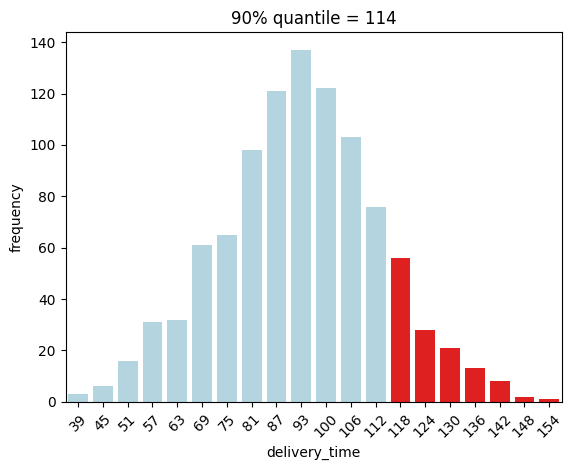

In [6]:
def interval_formating(time_group):
    time_group = str(time_group).split(',')[1].replace(' ', '').replace(']', '')
    upper_limit = round(float(time_group))
    return upper_limit

df = pd.DataFrame(values, columns=['time'])
df['time_group'] = pd.cut(df['time'], 20)
df['delivery_time'] = df['time_group'].apply(lambda x: interval_formating(x))
df_agg = df.groupby('delivery_time', as_index=False).agg(
    frequency=('time', 'count')
)
quantile_90 = round(df['time'].quantile(q=0.9))
above_or_below_quantile = ['red' if x > quantile_90 else 'lightblue' for x in df_agg['delivery_time']]

sns.barplot(data=df_agg, x='delivery_time', y='frequency', palette=above_or_below_quantile)
plt.xticks(rotation=45)
plt.title(f'90% quantile = {quantile_90}')
plt.show()

We can easily assess 90% quantile base on data, but how evaluate Standard Deviation of produced result?

It would be great if we had 100 parallel worlds from where we can get data :), we would calculate 100 different quantiles, evaluate standard deviation.

Someone can advice us to split our data of 1000 observations into 10 pieces of 100 in each. In each part we can calculate value of Quantile and evaluate Standard Deviation based on these 10 subsets.  
This approach is Missleading, since Standard Deviation depends on number of observations - the more data we have the more accurate evaluation we produce.

What we can do?  
Fortunately, there is method, which allows to evaluate Standard Deviation of some statistical value (Boostrap).

# Bootstrap

It is a method of Standard Deviation evaluation and determination of Confidence Intervals.

In the following example we will consider calculation of Standard Deviation of 90% quantile.

If we had access to the General Dataset (all deliveries in future), we could get 100 subset from there and calculate 100 Quantiles and evaluate Standard Deviation.  
We do not have Real Distribution, however, we can evaluate it based on the data available.

As an estimate of Distribution function, we will use the Empirical Distribution Function (EDF). EDF - is an unbiased estimator and converges to the tru DF as the sample size increases.

### Definition of DF and EDF

- Distribution Function (DF) of the random value X - is Function (Fx) Fx(x) = P(X < x)
- Empirical Distribution Function (EDF) - distribution function on the subset  
EDF - is DF of discrete random value if elements of subset are independent and equally distributed. If we give weight 1/n to each element of subset, we will have EDF

Let's see how EDF looks like on dta of different size from Normal distribution:

In [7]:
from scipy import stats

def plot_ecdf(values, label, xlim):
    """build EDF graph"""
    X_ = sorted(set(values))
    Y_ = [np.mean(values <= x) for x in X_]
    X = [xlim[0]] + sum([[v, v] for v in X_], []) + [xlim[1]]
    Y = [0, 0] + sum([[v, v] for v in Y_], [])
    plt.plot(X, Y, label=label)

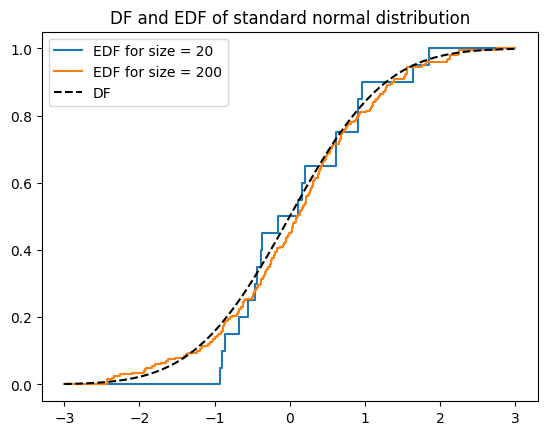

In [11]:
# generate data fir EDF:
for size in [20, 200]:
    values = np.random.normal(size=size)
    # plot EDF:
    plot_ecdf(values, f'EDF for size = {size}', [-3, 3])

# generate data for DF:
X = np.linspace(-3, 3, 1000)
Y = stats.norm.cdf(X)
# vis:
plt.plot(X, Y, '--', color='k', label='DF') # DF
plt.title('DF and EDF of standard normal distribution')
plt.legend()
plt.show()

From the graph we can see:
- with increase in size of subset, EDF is better representing DF. If we increase the size of the subset to several thousands, it will be difficult to visually distinguish EDF from DF.

Therefore, since we know that EDF is good approximation of DF we can try to get subsets from EDF. How can we do that?

Generating subset of size *n* from EDF - it the same as randomly pick *n* elements from General Dataset.  
Let's do this in code:

In [13]:
subset = np.random.choice(values, size=n, replace=True)

Now we can evaluate SD of 90% quantile evaluation. For this purpose, we will 1000 time generate subsets from EDF. Then calculate the quantile value for each subset and then evaluate Standard Deviation.